In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
# Load previously generated synthetic LC-MS grid from JSON
gaussians_grid = pd.read_json(r"C:\Users\victo\VSCode Folder\mass_spec_project\data\json\gaussians_grid.json")
print(gaussians_grid.head())

          rt                                                 mz  \
0  10.000000  [150, 150.0107917936, 150.0214675712, 150.0317...   
1  10.049022  [150, 150.0103545134, 150.0202744958, 150.0310...   
2  10.094543  [150, 150.0094729806, 150.0200318702, 150.0293...   
3  10.148506  [150, 150.0094058632, 150.0193528758, 150.0290...   
4  10.200007  [150, 150.009180935, 150.0198344818, 150.02974...   

                                         intensities  
0  [0.2197366292, 0.0, 0.0, 0.0, 0.0, 0.255882325...  
1  [0.1893830283, 0.0, 0.22610833530000002, 0.0, ...  
2  [0.11031056560000001, 0.2135564623, 0.0, 0.0, ...  
3  [0.5515372042000001, 0.7604282633, 0.616124777...  
4  [0.0215221041, 0.0, 0.0293257152, 0.0, 0.06009...  


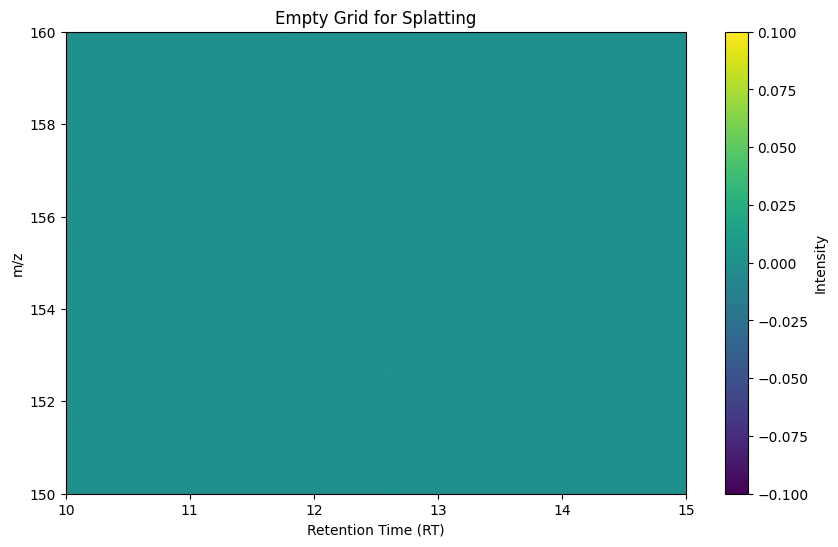

In [ ]:
# Define regular sampling axes for splatting
rt_axis = np.linspace(10, 15, 100)  # 100 RT points between 10 and 15 min
mz_axis = np.linspace(150, 160, 1000)  # 1000 m/z points between 150 and 160 Da

# Create an empty grid of zeros (m/z × RT)
X, Y = np.meshgrid(rt_axis, mz_axis)
grid = np.zeros_like(X)


# Quick visualization: Empty grid (all zeros)
plt.figure(figsize=(10, 6))
plt.imshow(grid, aspect='auto', extent=[rt_axis.min(), rt_axis.max(), mz_axis.min(), mz_axis.max()],
           origin='lower', cmap='viridis')
plt.xlabel('Retention Time (RT)')
plt.ylabel('m/z')
plt.title('Empty Grid for Splatting')
plt.colorbar(label='Intensity')
plt.show()

In [ ]:
# Splat (bin) the loaded sparse data into the regular grid
for _, row in gaussians_grid.iterrows():
    rt = row['rt'] # Retention Time
    mz_values = row['mz'] # List of m/z points
    intensity_values = row['intensities'] # Corresponding intensity values
    
    # Find nearest RT index
    rt_idx = np.abs(rt_axis - rt).argmin()
    
    for mz, intensity in zip(mz_values, intensity_values):
        # Find nearest m/z index
        mz_idx = np.abs(mz_axis - mz).argmin()
        # Add intensity into the corresponding grid bin
        grid[mz_idx, rt_idx] += intensity  # hard binning

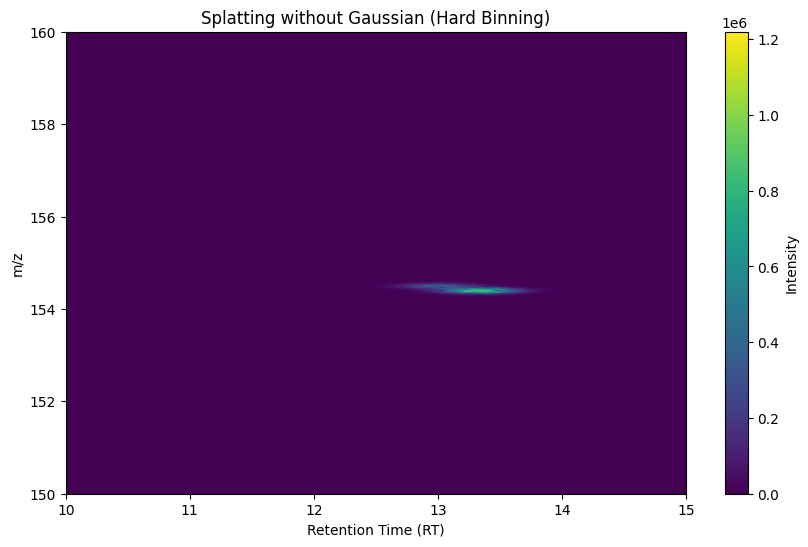

In [ ]:
# Plot the splatted grid (post-splatting)
plt.figure(figsize=(10, 6))
plt.imshow(grid, aspect='auto', extent=[rt_axis.min(), rt_axis.max(), mz_axis.min(), mz_axis.max()],
           origin='lower', cmap='viridis')
plt.xlabel('Retention Time (RT)')
plt.ylabel('m/z')
plt.title('Splatting without Gaussian (Hard Binning)')
plt.colorbar(label='Intensity')
plt.show()


In [ ]:
import numpy as np
from scipy.ndimage import gaussian_filter

# --- Smooth the Grid First
smoothed_grid = gaussian_filter(grid, sigma=1)  # small smoothing

# --- First Derivatives
d_grid_mz = np.diff(smoothed_grid, axis=0)
d_grid_rt = np.diff(smoothed_grid, axis=1)

# --- Second Derivatives
dd_grid_mz = np.diff(d_grid_mz, axis=0)
dd_grid_rt = np.diff(d_grid_rt, axis=1)

In [ ]:
def find_next_active_box(grid, processed_mask, mz_axis, rt_axis, 
                          global_intensity_thresh=0.01, local_margin=2):
    """
    Find the next active (non-processed, strong) region and grow a box around it.
    
    Parameters:
        grid (2D array): Smoothed intensity grid (m/z × RT)
        processed_mask (2D array): Boolean mask indicating already processed areas
        mz_axis (1D array): m/z values corresponding to grid rows
        rt_axis (1D array): RT values corresponding to grid columns
        global_intensity_thresh (float): Global intensity cutoff for "active" signal
        local_margin (int): Margin to pad around detected active region
    
    Returns:
        box (dict): {'mz_min', 'mz_max', 'rt_min', 'rt_max'} or None if no region found
    """

    global_max = np.max(grid)
    cutoff = global_max * global_intensity_thresh

    active_mask = (grid > cutoff) & (processed_mask == 'unprocessed')


    mz_bins, rt_bins = active_mask.shape

    # Find first unprocessed active pixel
    found = np.argwhere(active_mask)
    if found.size == 0:
        return None  # No more active regions

    start_mz_idx, start_rt_idx = found[0]

    # Grow the box starting from this point
    mz_min_idx, mz_max_idx, rt_min_idx, rt_max_idx = grow_box_from_start(
        active_mask, start_mz_idx, start_rt_idx
    )

    # Apply local margin
    mz_min_idx = max(mz_min_idx - local_margin, 0)
    mz_max_idx = min(mz_max_idx + local_margin, mz_bins - 1)
    rt_min_idx = max(rt_min_idx - local_margin, 0)
    rt_max_idx = min(rt_max_idx + local_margin, rt_bins - 1)

    # Build box
    box = {
        'mz_min': mz_axis[mz_min_idx],
        'mz_max': mz_axis[mz_max_idx],
        'rt_min': rt_axis[rt_min_idx],
        'rt_max': rt_axis[rt_max_idx],
        'mz_min_idx': mz_min_idx,
        'mz_max_idx': mz_max_idx,
        'rt_min_idx': rt_min_idx,
        'rt_max_idx': rt_max_idx
    }

    return box


def grow_box_from_start(active_mask, start_mz_idx, start_rt_idx):
    """
    Expand a bounding box from a starting active pixel using simple flood-fill.
    """

    mz_bins, rt_bins = active_mask.shape
    visited = np.zeros_like(active_mask, dtype=bool)
    to_visit = [(start_mz_idx, start_rt_idx)]

    mz_min_idx = mz_max_idx = start_mz_idx
    rt_min_idx = rt_max_idx = start_rt_idx

    while to_visit:
        mz_idx, rt_idx = to_visit.pop()

        if (mz_idx < 0 or mz_idx >= mz_bins or
            rt_idx < 0 or rt_idx >= rt_bins or
            visited[mz_idx, rt_idx] or
            not active_mask[mz_idx, rt_idx]):
            continue  # Skip

        visited[mz_idx, rt_idx] = True

        mz_min_idx = min(mz_min_idx, mz_idx)
        mz_max_idx = max(mz_max_idx, mz_idx)
        rt_min_idx = min(rt_min_idx, rt_idx)
        rt_max_idx = max(rt_max_idx, rt_idx)

        # Add neighbors to check
        neighbors = [
            (mz_idx-1, rt_idx), (mz_idx+1, rt_idx),
            (mz_idx, rt_idx-1), (mz_idx, rt_idx+1)
        ]
        to_visit.extend(neighbors)

    return mz_min_idx, mz_max_idx, rt_min_idx, rt_max_idx

In [36]:
def crop_box(grid, mz_axis, rt_axis, box):
    """
    Extract a cropped version of the grid and axes inside a given box.
    
    Returns:
        cropped_grid, cropped_mz_axis, cropped_rt_axis
    """
    mz_slice = slice(box['mz_min_idx'], box['mz_max_idx'] + 1)
    rt_slice = slice(box['rt_min_idx'], box['rt_max_idx'] + 1)
    
    cropped_grid = grid[mz_slice, rt_slice]
    cropped_mz_axis = mz_axis[mz_slice]
    cropped_rt_axis = rt_axis[rt_slice]
    
    return cropped_grid, cropped_mz_axis, cropped_rt_axis

def mark_box(processed_mask, box, label):
    """
    Mark a given box inside the processed_mask array with a label ('singular' or 'overlapping').
    """
    mz_slice = slice(box['mz_min_idx'], box['mz_max_idx'] + 1)
    rt_slice = slice(box['rt_min_idx'], box['rt_max_idx'] + 1)
    
    processed_mask[mz_slice, rt_slice] = label


In [ ]:
def estimate_peak_widths(grid, mz_axis, relative_threshold=0.05) -> np.array:
    """
    Estimate peak widths across RT by using a fixed intensity threshold.
    
    Parameters:
        grid (2D np.array): Smoothed intensity grid (m/z × RT)
        mz_axis (1D np.array): Array of m/z values corresponding to grid rows
        relative_threshold (float): Fraction of global maximum intensity to define peak region
    
    Returns:
        np.array: Array of peak widths (in m/z units) per RT column
    """
    # Initialize empty widths array (one width per RT point)
    widths = np.zeros(grid.shape[1])
    
    # Find the global maximum intensity in the entire grid
    global_max = np.max(grid)
    cutoff = global_max * relative_threshold
    
    # Loop over each RT point (each column in the grid)
    for j in range(grid.shape[1]):
        column = grid[:, j]

        # Find all m/z indices where intensity is above cutoff
        indices_above_cutoff = np.where(column >= cutoff)[0]
        
        if len(indices_above_cutoff) > 1:
            # Calculate width as m/z difference between last and first above-threshold point
            width = mz_axis[indices_above_cutoff[-1]] - mz_axis[indices_above_cutoff[0]]
            widths[j] = width
        else:
            # Not enough points above threshold ➔ No meaningful peak width
            widths[j] = 0
    
    return widths

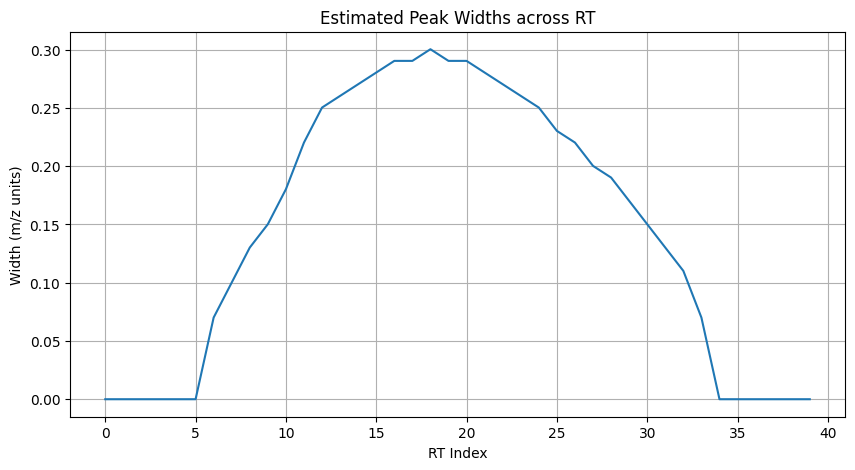

Total boxes found: 1


In [87]:
# Before
processed_mask = np.zeros_like(grid, dtype=bool)

# Now
processed_mask = np.full_like(grid, fill_value='unprocessed', dtype=object)

# Initialize
all_boxes = []

# Main Processing Loop
while 'unprocessed' in processed_mask:
    # 1. Find next box
    box = find_next_active_box(smoothed_grid, processed_mask, mz_axis, rt_axis, global_intensity_thresh=0.001)
    
    if box is None:
        break  # No more active regions
    
    # 2. Save box info
    all_boxes.append(box)
    
    # 3. Crop grid inside the box
    cropped_grid, cropped_mz_axis, cropped_rt_axis = crop_box(smoothed_grid, mz_axis, rt_axis, box)
    
    # 4. Estimate peak widths (inside box)
    local_widths = estimate_peak_widths(cropped_grid, cropped_mz_axis, relative_threshold=0.02)
    # Plot it
    plt.figure(figsize=(10,5))
    plt.plot(local_widths)
    plt.title('Estimated Peak Widths across RT')
    plt.xlabel('RT Index')
    plt.ylabel('Width (m/z units)')
    plt.grid(True)
    plt.show()

    mark_box(processed_mask, box, label='singular')
    
    """ # 5. Check if signal is suspicious
    suspicious = check_suspicious_signals(local_widths, cropped_grid)
    
    # 6. Action depending on suspiciousness
    if suspicious:
        run_micro_dbscan(cropped_grid)
        mark_box(processed_mask, box, label='overlapping')
    else:
        label_as_normal_peak(cropped_grid)
        mark_box(processed_mask, box, label='singular')
 """
# 7. Summary
print(f"Total boxes found: {len(all_boxes)}")


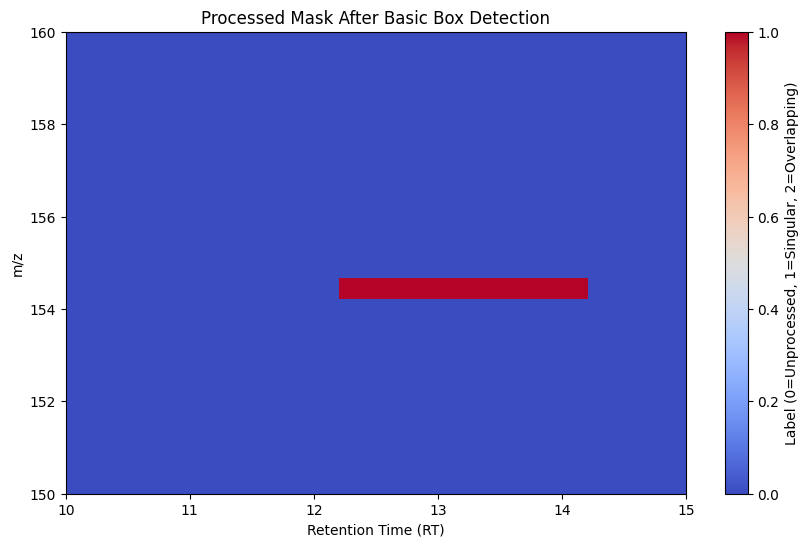

In [84]:
import matplotlib.pyplot as plt

def plot_processed_mask(processed_mask, mz_axis, rt_axis, title="Processed Mask"):
    """
    Plot the processed mask using the correct m/z and RT axis extents.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Build a numerical mask: unprocessed=0, singular=1, overlapping=2
    numeric_mask = np.zeros_like(processed_mask, dtype=float)
    numeric_mask[processed_mask == 'singular'] = 1
    numeric_mask[processed_mask == 'overlapping'] = 2

    extent = [rt_axis[0], rt_axis[-1], mz_axis[0], mz_axis[-1]]  # Real world scaling

    img = ax.imshow(numeric_mask, 
                    extent=extent, 
                    aspect='auto', 
                    origin='lower', 
                    cmap='coolwarm', 
                    interpolation='nearest')

    cbar = plt.colorbar(img, ax=ax, label='Label (0=Unprocessed, 1=Singular, 2=Overlapping)')
    ax.set_xlabel('Retention Time (RT)')
    ax.set_ylabel('m/z')
    ax.set_title(title)
    plt.grid(False)
    plt.show()

plot_processed_mask(processed_mask, mz_axis, rt_axis, title="Processed Mask After Basic Box Detection")



In [ ]:
while 'unprocessed' in processed_mask:
    box = find_next_active_box(smoothed_grid, processed_mask, mz_axis, rt_axis, debug=True)

    if box is None:
        break

    # 1. Crop data inside box
    cropped_grid, cropped_mz_axis, cropped_rt_axis = crop_box(smoothed_grid, mz_axis, rt_axis, box)

    # 2. Analyze the small cropped grid
    local_widths = estimate_peak_widths(cropped_grid, cropped_mz_axis)

    suspicious = check_suspicious_signals(local_widths, cropped_grid)

    # 3. Run DBSCAN only if suspicious
    if suspicious:
        run_micro_dbscan(cropped_grid)
        mark_box(processed_mask, box, label='overlapping')
    else:
        label_as_normal_peak(cropped_grid)
        mark_box(processed_mask, box, label='singular')



NameError: name 'processed_mask' is not defined

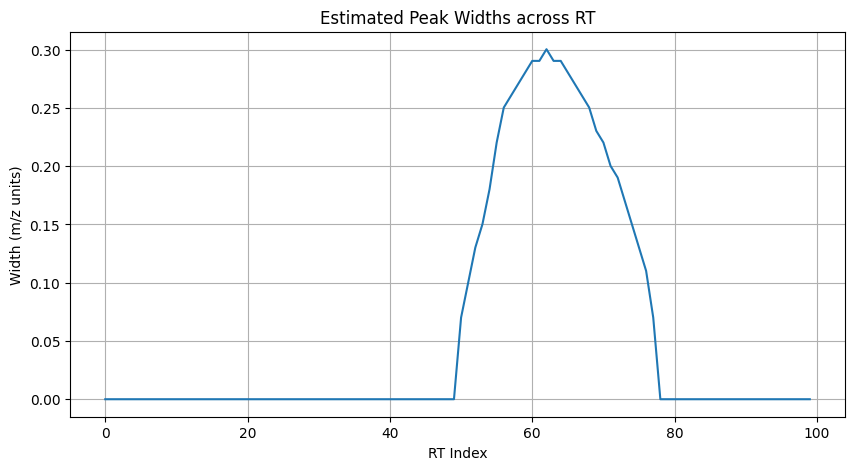

In [17]:
def estimate_peak_widths(grid, mz_axis, relative_threshold=0.05) -> np.array:
    """
    Estimate peak widths across RT by using a fixed intensity threshold.
    
    Parameters:
        grid (2D np.array): Smoothed intensity grid (m/z × RT)
        mz_axis (1D np.array): Array of m/z values corresponding to grid rows
        relative_threshold (float): Fraction of global maximum intensity to define peak region
    
    Returns:
        np.array: Array of peak widths (in m/z units) per RT column
    """
    # Initialize empty widths array (one width per RT point)
    widths = np.zeros(grid.shape[1])
    
    # Find the global maximum intensity in the entire grid
    global_max = np.max(grid)
    cutoff = global_max * relative_threshold
    
    # Loop over each RT point (each column in the grid)
    for j in range(grid.shape[1]):
        column = grid[:, j]

        # Find all m/z indices where intensity is above cutoff
        indices_above_cutoff = np.where(column >= cutoff)[0]
        
        if len(indices_above_cutoff) > 1:
            # Calculate width as m/z difference between last and first above-threshold point
            width = mz_axis[indices_above_cutoff[-1]] - mz_axis[indices_above_cutoff[0]]
            widths[j] = width
        else:
            # Not enough points above threshold ➔ No meaningful peak width
            widths[j] = 0
    
    return widths

peak_widths = estimate_peak_widths(smoothed_grid, mz_axis, relative_threshold=0.02)  # 2% cutoff

# Plot it
plt.figure(figsize=(10,5))
plt.plot(peak_widths)
plt.title('Estimated Peak Widths across RT')
plt.xlabel('RT Index')
plt.ylabel('Width (m/z units)')
plt.grid(True)
plt.show()


✅

Detect where the peak zone starts and ends.

Highlight the broadening effect of overlapping peaks.

Ignore flat noise regions properly.


In [18]:
import numpy as np

# Collapse derivatives along the m/z axis (take maximum per RT column)
d_grid_rt_1d = np.max(np.abs(d_grid_rt), axis=0) # slope steepness
dd_grid_rt_1d = np.max(np.abs(dd_grid_rt), axis=0) # curvature sharpness

def detect_suspicious_steps(peak_widths, d_grid_rt_1d, dd_grid_rt_1d, 
                             width_increase_thresh=0.2, 
                             slope_change_thresh=0.5, 
                             curvature_flat_thresh=0.2,
                             min_width_threshold=0.01):
    """
    Detect suspicious zones across Retention Time (RT) by combining:
    - Width expansion detection
    - Slope anomaly detection (1st derivative)
    - Curvature flattening detection (2nd derivative with noise gating)

    Parameters:
        peak_widths (np.array): 1D array of estimated peak widths vs RT
        d_grid_rt_1d (np.array): 1D array of maximum first derivative vs RT
        dd_grid_rt_1d (np.array): 1D array of maximum second derivative vs RT
        width_increase_thresh (float): Relative threshold for width expansion detection
        slope_change_thresh (float): Relative threshold for slope anomaly detection
        curvature_flat_thresh (float): Relative threshold for curvature flattening detection
        min_width_threshold (float): Minimum peak width for valid curvature flattening (noise gating)

    Returns:
        Tuple:
            - suspicious_mask (np.array): Combined mask of all suspicious detections
            - width_growth_full (np.array): Individual width growth detections
            - slope_anomaly_full (np.array): Individual slope anomaly detections
            - curvature_flat_full (np.array): Individual curvature flattening detections
    """

    # Width Expansion Detection
    width_diff = np.diff(peak_widths) # First difference along RT
    width_growth = width_diff > (width_increase_thresh * np.maximum(peak_widths[:-1], 1e-6))

    # First Derivative Slope Anomaly Detection
    max_slope = np.max(np.abs(d_grid_rt_1d))
    slope_anomaly = np.abs(d_grid_rt_1d) > (slope_change_thresh * max_slope)

    # Second Derivative Curvature Flattening Detection
    max_curvature = np.max(np.abs(dd_grid_rt_1d))
    curvature_flat_raw = np.abs(dd_grid_rt_1d) < (curvature_flat_thresh * max_curvature)

    # Noise Gating on Curvature
    peak_widths_cut = peak_widths[:-2]  # Align due to two diffs
    curvature_flat = curvature_flat_raw & (peak_widths_cut > min_width_threshold)

    # Align lengths by padding
    width_growth_full = np.concatenate([width_growth, [False]])   # +1
    slope_anomaly_full = np.concatenate([slope_anomaly, [False]]) # +1
    curvature_flat_full = np.concatenate([curvature_flat, [False, False]]) # +2

    # Combine
    suspicious_mask = width_growth_full | slope_anomaly_full | curvature_flat_full

    return suspicious_mask, width_growth_full, slope_anomaly_full, curvature_flat_full


# Call it
suspicious_mask, width_growth_full, slope_anomaly_full, curvature_flat_full = detect_suspicious_steps(
    peak_widths, 
    d_grid_rt_1d, 
    dd_grid_rt_1d
)

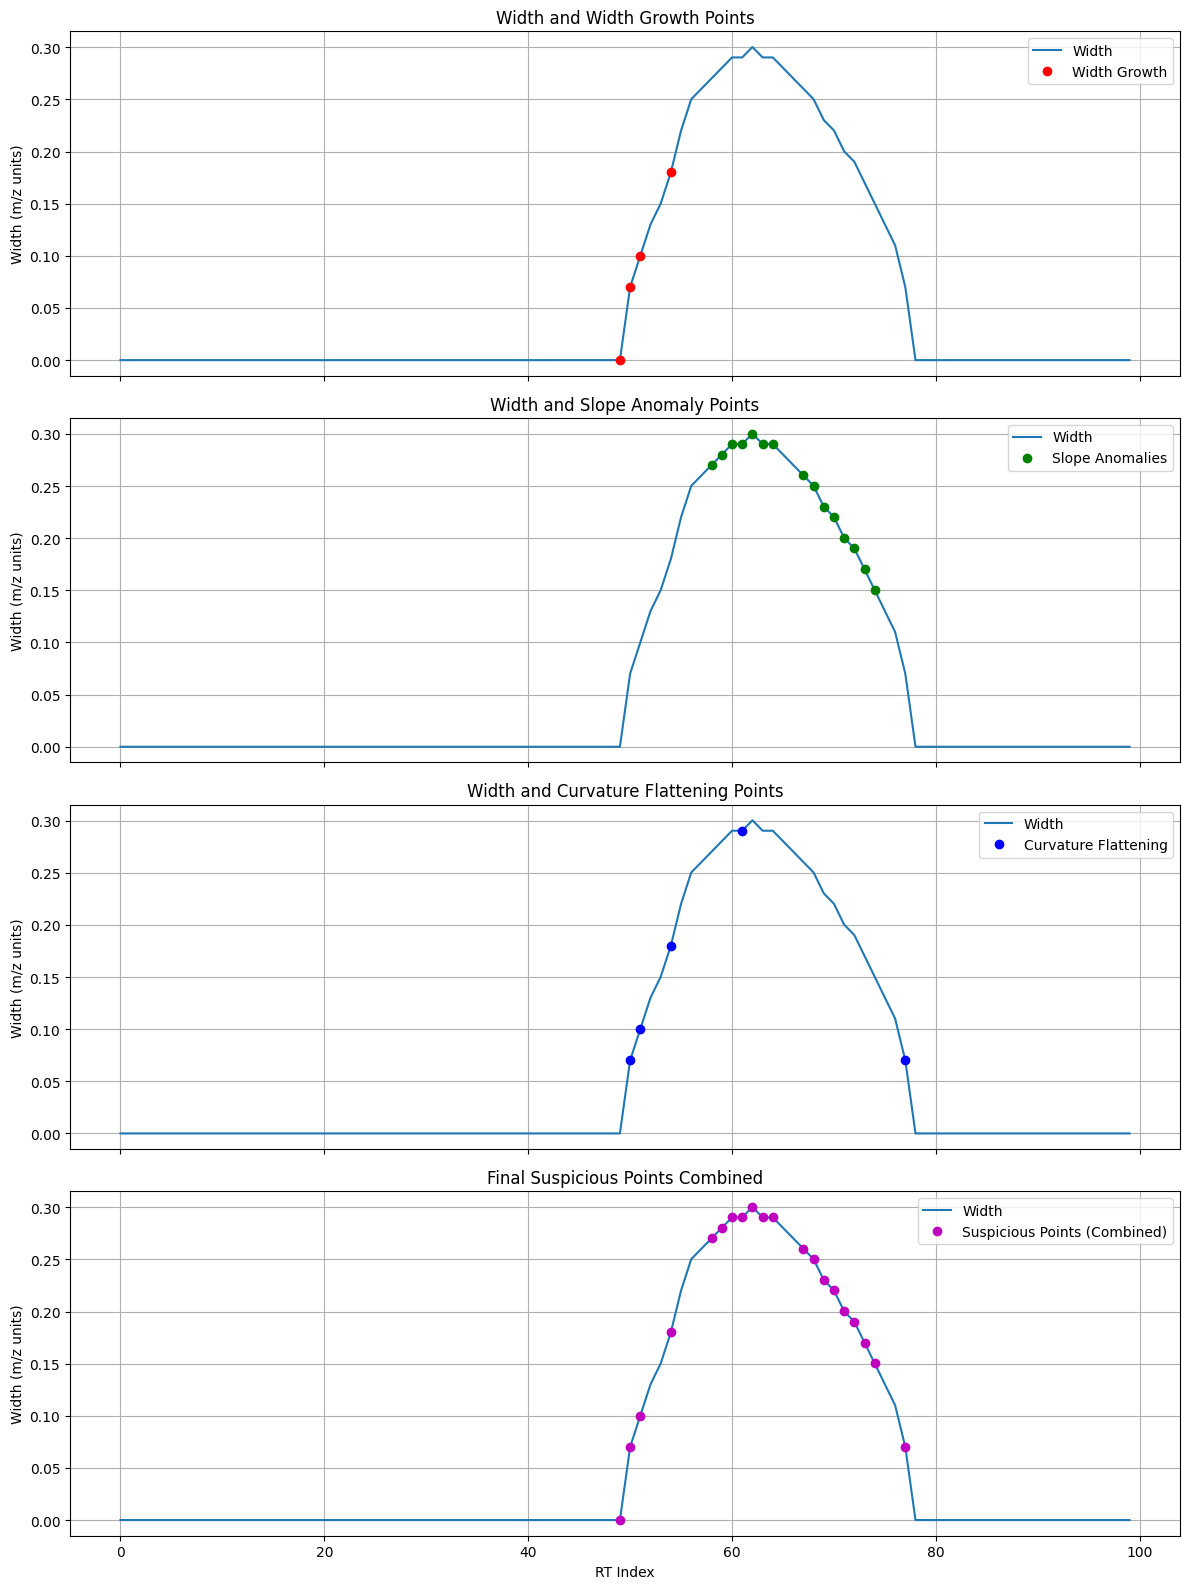

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

# Plot 1: Width
axes[0].plot(peak_widths, label='Width')
axes[0].plot(np.where(width_growth_full, peak_widths, np.nan), 'ro', label='Width Growth')
axes[0].set_ylabel('Width (m/z units)')
axes[0].legend()
axes[0].set_title('Width and Width Growth Points')
axes[0].grid(True)

# Plot 2: Slope Anomalies
axes[1].plot(peak_widths, label='Width')
axes[1].plot(np.where(slope_anomaly_full, peak_widths, np.nan), 'go', label='Slope Anomalies')
axes[1].set_ylabel('Width (m/z units)')
axes[1].legend()
axes[1].set_title('Width and Slope Anomaly Points')
axes[1].grid(True)

# Plot 3: Curvature Flattening
axes[2].plot(peak_widths, label='Width')
axes[2].plot(np.where(curvature_flat_full, peak_widths, np.nan), 'bo', label='Curvature Flattening')
axes[2].set_ylabel('Width (m/z units)')
axes[2].legend()
axes[2].set_title('Width and Curvature Flattening Points')
axes[2].grid(True)

# Plot 4: Combined Suspicious Points
axes[3].plot(peak_widths, label='Width')
axes[3].plot(np.where(suspicious_mask, peak_widths, np.nan), 'mo', label='Suspicious Points (Combined)')
axes[3].set_ylabel('Width (m/z units)')
axes[3].legend()
axes[3].set_title('Final Suspicious Points Combined')
axes[3].set_xlabel('RT Index')
axes[3].grid(True)

plt.tight_layout()
plt.show()


| Plot | What We Test | What It Catches | When It Triggers |
|:-----|:-------------|:----------------|:----------------|
| Plot 1 (Red) | Sudden width expansion | Early peak growth | If width grows too fast between neighboring RT points. |
| Plot 2 (Green) | Slope anomalies | Top of peak | If slope behavior becomes too sharp or irregular. |
| Plot 3 (Blue) | Curvature flattening | Top and sides of peak | If the peak top becomes too flat (less pointy). |
| Plot 4 (Magenta) | Combination | Everything flagged | If any of the three features say "suspicious". |


In [21]:
def group_suspicious_zones(suspicious_mask, min_zone_size=3, merge_gap=2):
    """
    Group consecutive suspicious points into zones.
    Optionally merge zones if they are close together.
    
    Parameters:
        suspicious_mask (np.array): Boolean array where True = suspicious.
        min_zone_size (int): Minimum size of a valid suspicious zone.
        merge_gap (int): Maximum gap between zones to auto-merge.

    Returns:
        List of tuples: (start_index, end_index)
    """
    zones = []
    start_idx = None # Keeps track of where a suspicious zone starts

    # Step 1: Identify raw suspicious zones
    for i, val in enumerate(suspicious_mask):
        if val and start_idx is None:
            # Start of a new suspicious zone
            start_idx = i
        elif not val and start_idx is not None:
            # End of a suspicious zone
            if (i - start_idx) >= min_zone_size:
                zones.append((start_idx, i - 1))
            start_idx = None # Reset

    # Step 2: Merge nearby zones if gap is small enough
    if start_idx is not None and (len(suspicious_mask) - start_idx) >= min_zone_size:
        zones.append((start_idx, len(suspicious_mask) - 1))

    # Merge zones that are very close
    if merge_gap > 0 and len(zones) > 1:
        merged_zones = []
        current_start, current_end = zones[0]

        for next_start, next_end in zones[1:]:
            if next_start - current_end <= merge_gap:
                # Zones are close enough ➔ Merge
                current_end = next_end
            else:
                # Zones are too far apart ➔ Save current zone and move on
                merged_zones.append((current_start, current_end))
                current_start, current_end = next_start, next_end

        # Add last zone
        merged_zones.append((current_start, current_end))
        zones = merged_zones

    return zones

def plot_zones_over_width(peak_widths, zones, title="Suspicious Zones over Width Curve"):
    """
    Plot peak width curve across RT and shade detected suspicious zones.

    Parameters:
        peak_widths (np.array): Array of estimated peak widths vs RT index.
        zones (List[Tuple[int, int]]): List of (start, end) RT index ranges for suspicious zones.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(14,6))
    # Plot the base peak width curve
    plt.plot(peak_widths, label='Estimated Peak Width', color='black')

    # Shade suspicious zones
    for (start, end) in zones:
        plt.axvspan(start, end, color='red', alpha=0.3)

    plt.xlabel('RT Index')
    plt.ylabel('Width (m/z units)')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()


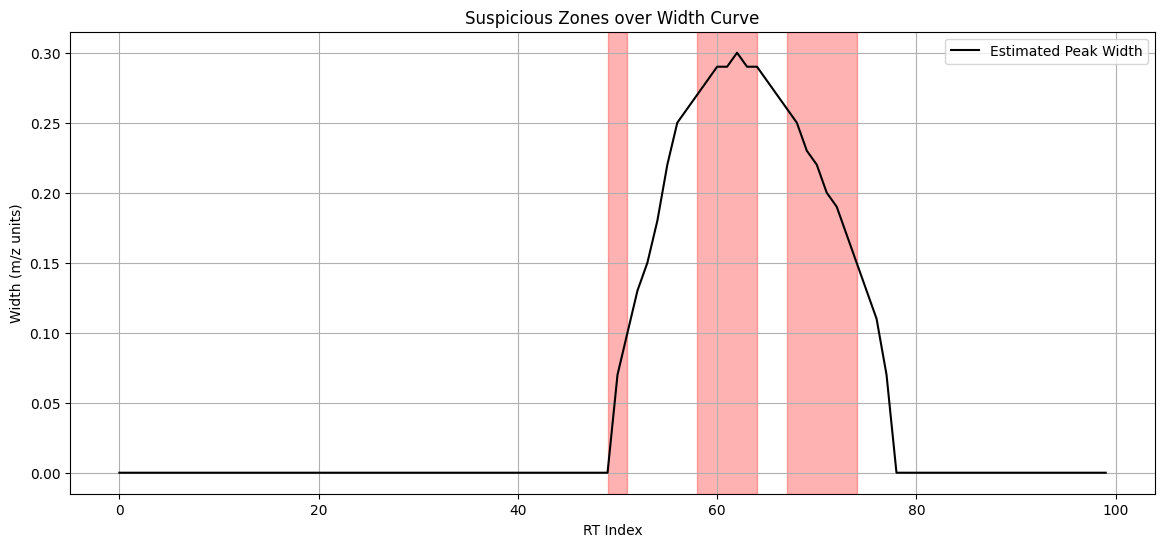

In [16]:
zones = group_suspicious_zones(suspicious_mask, min_zone_size=3, merge_gap=2)
plot_zones_over_width(peak_widths, zones)


In [27]:
def find_first_full_peak_by_width(peak_widths, min_width_threshold=0.01):
    """
    Find the first full RT region corresponding to a peak based on peak widths.

    Parameters:
        peak_widths (np.array): Array of peak width estimates.
        min_width_threshold (float): Width value to consider "inside" a peak.

    Returns:
        (start_idx, end_idx): Tuple of RT index start and end.
    """
    inside_peak = False
    start_idx = None

    for i, width in enumerate(peak_widths):
        if width > min_width_threshold and not inside_peak:
            start_idx = i
            inside_peak = True
        elif width <= min_width_threshold and inside_peak:
            end_idx = i-1
            return start_idx, end_idx

    if inside_peak:
        return start_idx, len(peak_widths) - 1

    return None, None  # No peak found


In [28]:
# Simple voting threshold
if len(zones) >= 1:  # or whatever rule you choose
    analyze_further = True
    print(True)
else:
    analyze_further = False


# Step 3: If voting says "yes", find full peak
if analyze_further:
    start_idx, end_idx = find_first_full_peak_by_width(peak_widths, min_width_threshold=0.01)

    if start_idx is not None and end_idx is not None:
        print(f"Full peak detected from RT index {start_idx} to {end_idx}")
        
        # ✅ We are ready here for the next steps
        # Later we will slice the smoothed_grid[start:end] and then do DBSCAN

    else:
        print("No full peak detected after suspicious voting.")
else:
    print("No suspicious zones voted for deeper analysis.")

True
Full peak detected from RT index 50 to 77


In [22]:
from sklearn.cluster import DBSCAN
import numpy as np

def run_micro_dbscan(smoothed_grid, rt_axis, mz_axis, 
                     zone_start, zone_end,
                     intensity_thresh_ratio=0.05,
                     dbscan_eps=0.01, dbscan_min_samples=5):
    """
    Run DBSCAN inside a suspicious zone to detect overlapping peaks.

    Parameters:
        smoothed_grid (np.array): Smoothed intensity grid (m/z × RT).
        rt_axis (np.array): Retention time axis.
        mz_axis (np.array): m/z axis.
        zone_start (int): Start RT index of the suspicious zone.
        zone_end (int): End RT index of the suspicious zone.
        intensity_thresh_ratio (float): Relative threshold for including a point.
        dbscan_eps (float): DBSCAN neighborhood radius (RT units).
        dbscan_min_samples (int): Minimum points to form a cluster in DBSCAN.

    Returns:
        bool: True if multiple peaks detected, False otherwise.
    """

    # --- Step 1: Extract small patch
    patch = smoothed_grid[:, zone_start:zone_end+1]
    rt_subaxis = rt_axis[zone_start:zone_end+1]
    mz_subaxis = mz_axis

    # --- Step 2: Build point cloud (RT, m/z) for strong points
    points = []
    intensity_threshold = np.max(patch) * intensity_thresh_ratio

    for rt_idx, rt in enumerate(rt_subaxis):
        for mz_idx, mz in enumerate(mz_subaxis):
            intensity = patch[mz_idx, rt_idx]
            if intensity >= intensity_threshold:
                points.append([rt, mz])

    if len(points) == 0:
        # No strong points: likely noise
        return False

    points = np.array(points)

    # --- Step 3: Run DBSCAN
    db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
    labels = db.fit_predict(points)

    # Count number of real clusters (ignore label = -1, which is noise)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # --- Step 4: Early decision
    return n_clusters >= 2
